In [1]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

In [2]:
# Load the labeled index data from csv
labeled_index_df = pd.read_csv("/Users/elroylo/Documents/GitHub/fyp-2024/data/merge_file_3m.csv")

## Build the model

In [3]:
# Set up datasets
exclude_col = ['Date_modified','index','price','volume','date','crash_label', 'Date_y', 'Date_x','Date']
X = labeled_index_df.drop(exclude_col, axis=1)
y = labeled_index_df['crash_label']

feature_names = list(X.columns)
print(feature_names)
# Determine non-numeric attribute names
for feature in feature_names:
    X[feature] = X[feature].astype('float64')

['price_change', 'volume_change', 'volatility', 'Total_Equity_Risk_Premium_US', 'Population_US', 'Unemployment_US', 'Inflation_Rate_US', 'housing_US', 'Long-Term_Government_Bond Yields_US', 'turnover_US', 'Recession_Indicators_US', 'GDP_US', 'Recession_Indicators_UK', 'FX_Rate_UK', 'GDP_UK', 'housing_UK', 'Long-Term_Government_Bond Yields_UK', 'turnover_UK', 'Inflation_Rate_UK', 'Unemployment_UK', 'Total_Equity_Risk_Premium_UK', 'Population_UK', 'Unemployment_HK', 'Total_Equity_Risk_Premium_HK', 'Population_HK', 'Recession_Indicators_HK', 'FX_Rate_HK', 'GDP_HK', 'housing_HK', 'Long-Term_Government_Bond Yields_HK', 'turnover_HK', 'Inflation_Rate_HK', 'FX_Rate_Japan', 'Inflation_Rate_Japan', 'Recession_Indicators_Japan', 'Unemployment_Japan', 'Total_Equity_Risk_Premium_Japan', 'turnover_Japan', 'GDP_Japan', 'housing_Japan', 'Population_Japan', 'Long-Term_Government_Bond Yields_Japan', 'Long-Term_Government_Bond Yields_China', 'Population_China', 'housing_China', 'GDP_China', 'turnover_Ch

In [4]:
# Handle extreme value
X[~np.isfinite(X)] = np.finfo(np.float64).max
X = np.clip(X, -1e6, 1e6) 

# Handle NaN
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

In [5]:
# Split the training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
# Oversample the minority class (1) using SMOTE
oversampler = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

# Undersample the majority class (0) using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)

param_grid = {
    "penalty": ['l1','l2'],
    'C': [0.0001,0.001,0.01, 0.1, 1],
    'solver': ['sag', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5,verbose=2)

try:
    grid_search.fit(X_train_scaled, y_train_resampled)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best Score: {best_score}")
    print("Grid search completed successfully.")
except Exception as e:
    print("Error occurred during grid search:")
    print(e)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...................C=0.0001, penalty=l1, solver=sag; total time=   6.3s
[CV] END ...................C=0.0001, penalty=l1, solver=sag; total time=   6.1s
[CV] END ...................C=0.0001, penalty=l1, solver=sag; total time=   5.6s
[CV] END ...................C=0.0001, penalty=l1, solver=sag; total time=   5.7s
[CV] END ...................C=0.0001, penalty=l1, solver=sag; total time=   4.4s
[CV] END ..................C=0.0001, penalty=l1, solver=saga; total time=11.5min
[CV] END ..................C=0.0001, penalty=l1, solver=saga; total time= 9.2min
[CV] END ..................C=0.0001, penalty=l1, solver=saga; total time= 9.4min
[CV] END ..................C=0.0001, penalty=l1, solver=saga; total time= 9.2min
[CV] END ..................C=0.0001, penalty=l1, solver=saga; total time= 9.3min
[CV] END ...................C=0.0001, penalty=l2, solver=sag; total time= 1.5min
[CV] END ...................C=0.0001, penalty=l

In [8]:
# Train the model
model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
model.fit(X_train_scaled, y_train_resampled)

LogisticRegression(C=1, solver='saga')

## Model Evaluation 
- Precision: number of True Positives / (number of True Positives + number of False Positives)
- Recall: number of True Positives / (number of True Positives + number of False Negatives)
- F1 score: A weighted average of precision and recall, F1 = 2*((precision*recall)/(precision+recall))

In [9]:
# Evaluate the model
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9193558398489023
Confusion Matrix:
[[820048  36360]
 [ 36397   9393]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    856408
         1.0       0.21      0.21      0.21     45790

    accuracy                           0.92    902198
   macro avg       0.58      0.58      0.58    902198
weighted avg       0.92      0.92      0.92    902198



Problem: low recall and f1 score for crash label 1

## Feature Importance

Feature: price_change, Importance: -0.56887807554976
Feature: volume_change, Importance: -0.13978764385278403
Feature: volatility, Importance: -1.0617133192980928
Feature: Total_Equity_Risk_Premium_US, Importance: -2.3336878060871076
Feature: Population_US, Importance: -3.4038668885799845
Feature: Unemployment_US, Importance: 2.1215861658473236
Feature: Inflation_Rate_US, Importance: 0.23333120198720875
Feature: housing_US, Importance: 0.5785580304306396
Feature: Long-Term_Government_Bond Yields_US, Importance: 0.0809852317762691
Feature: turnover_US, Importance: 0.4717637300627086
Feature: Recession_Indicators_US, Importance: -0.582751065812498
Feature: GDP_US, Importance: -2.602724681887317
Feature: Recession_Indicators_UK, Importance: -0.08697008420225709
Feature: FX_Rate_UK, Importance: -0.7763546524642774
Feature: GDP_UK, Importance: -2.2543659190108913
Feature: housing_UK, Importance: -0.05129200671992652
Feature: Long-Term_Government_Bond Yields_UK, Importance: -0.40030639103609

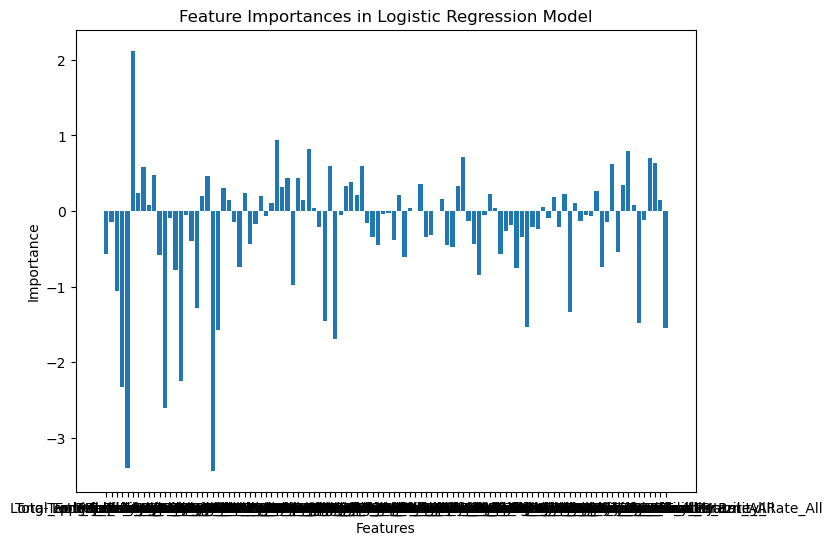

In [10]:
feature_importance = model.coef_[0]
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

plt.figure(figsize=(8, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importances in Logistic Regression Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## K-fold Validation

In [ ]:
# Perform 10-fold cross-validation
scores = cross_val_score(model, X, y, cv=10)

# Print the cross-validation scores
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

## Prediction Result

In [ ]:
y_prob = model.predict_proba(X_test)
crash_prob = y_prob[:, 1]
print(f"Crash Probability: {crash_prob.mean()}")

## AUC-ROC

In [ ]:
auc_roc = roc_auc_score(y_test, y_prob[:, 1])

print("AUC-ROC Score:", auc_roc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, -1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
for month, model in model_dict.items():
    print(month, "prediction model:")
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    
    print(f"Accuracy: {accuracy}")
    print(f"RMSE: {rmse}")
    print(f'MAPE: {mape}%') 